In [1]:
import numpy as np
import matplotlib.pyplot as plt

from silx.image.projection import Projection
from ppfft.tools.pad import pad
from ppfft.reconstruction.polar_to_pp import polar_coordinates, direct_2d_interp
from ppfft.inverse.fast_direct_inverse import fast_direct_inversion, precompute_all
from ppfft.inverse.iterative_inverse import iterative_inverse

In [2]:
phantom = plt.imread("Shepp_logan_240.png")
n = phantom.shape[0]
m = 2 * n + 1

theta = - np.pi / 2 +  np.pi * np.arange(2 * n) / (2 * n) # with 2n projections

proj = Projection(phantom.shape, angles=theta)
sinogram = proj.projection(phantom)
pad_sino = pad(sinogram, (2 * n, m))
fft_sinogram = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pad_sino, axes=-1)), axes=-1)

In [3]:
polar_coords = polar_coordinates(n)
hori_ppfft, vert_ppfft = direct_2d_interp(fft_sinogram.flatten(), polar_coords[..., 0].T, polar_coords[..., 1].T, n)

In [4]:
precomputations = precompute_all(n)

In [5]:
sol_direct = fast_direct_inversion(hori_ppfft, vert_ppfft, precomputations)

[None, None, None, None]

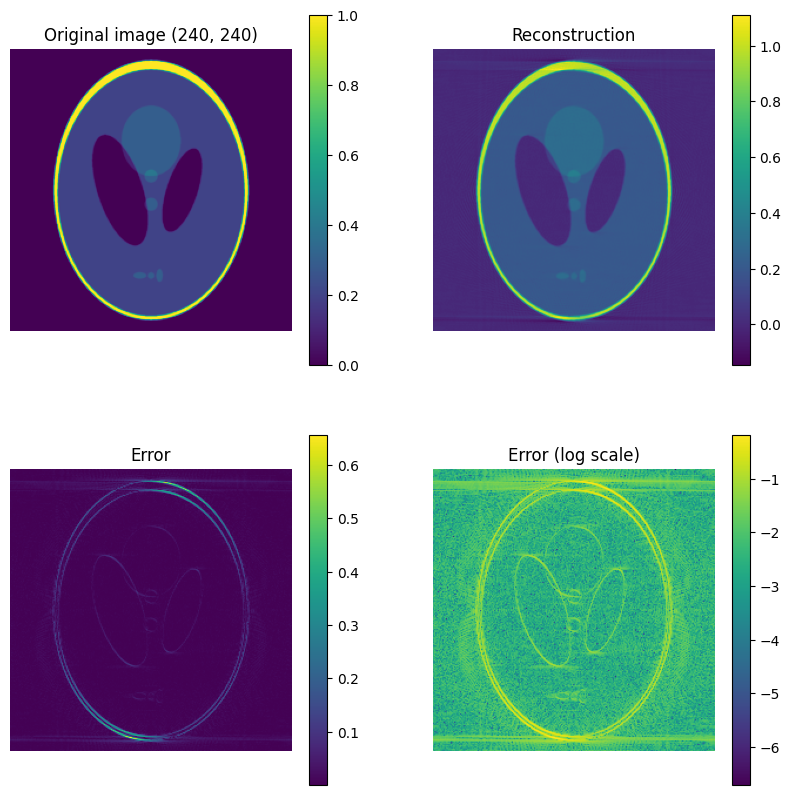

In [6]:
sol = sol_direct.real

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

a = axes[0, 0].imshow(phantom)
plt.colorbar(a, ax=axes[0, 0])
axes[0, 0].set_title(f"Original image {phantom.shape}")

a = axes[0, 1].imshow(sol)
plt.colorbar(a, ax=axes[0, 1])
axes[0, 1].set_title(f"Reconstruction")

a = axes[1, 0].imshow(np.abs(sol - phantom))
plt.colorbar(a, ax=axes[1, 0])
axes[1, 0].set_title("Error")

a = axes[1, 1].imshow(np.log10(np.abs(sol - phantom)))
plt.colorbar(a, ax=axes[1, 1])
axes[1, 1].set_title("Error (log scale)")

[ax.set_axis_off() for ax in axes.ravel()]

In [38]:
def fast_reconstruction(sino, precomputations, angles=None, tol=1e-3):
    """
    The angles of the projections are supposed to be equispaced in [-pi/2, pi/2[
    """

    n_theta, n = sino.shape

    pad_sino = pad(sino, (n_theta, 2 * n + 1))
    fft_sinogram = np.fft.fftshift(
        np.fft.fft(np.fft.ifftshift(pad_sino, axes=-1)), axes=-1
    )

    if angles is None:
        angles = np.linspace(-np.pi / 2, np.pi / 2, num=n_theta, endpoint=False)

    p = np.arange(-n, n + 1)

    x_polar = p[None, :] * np.cos(np.pi / 2 + angles)[:, None]
    y_polar = p[None, :] * np.sin(np.pi / 2 + angles)[:, None]

    hori_ppfft, vert_ppfft = direct_2d_interp(fft_sinogram, x_polar, y_polar, n)

    if tol is None:
        return fast_direct_inversion(hori_ppfft, vert_ppfft, precomputations)

    else:
        res, info = iterative_inverse(hori_ppfft, vert_ppfft, tol)
        if info != 0:
            print("WARNING: convergence to tolerance not achieved")
        return res

In [8]:
phantom = plt.imread("Shepp_logan_240.png")
n = phantom.shape[0]
m = 2 * n + 1

theta = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n) # with n projections this time

proj = Projection(phantom.shape, angles=theta)
sinogram = proj.projection(phantom)

In [9]:
precomputations = precompute_all(n)

In [10]:
sol = fast_reconstruction(sinogram, precomputations, angles=theta, tol=None)

[None, None, None, None]

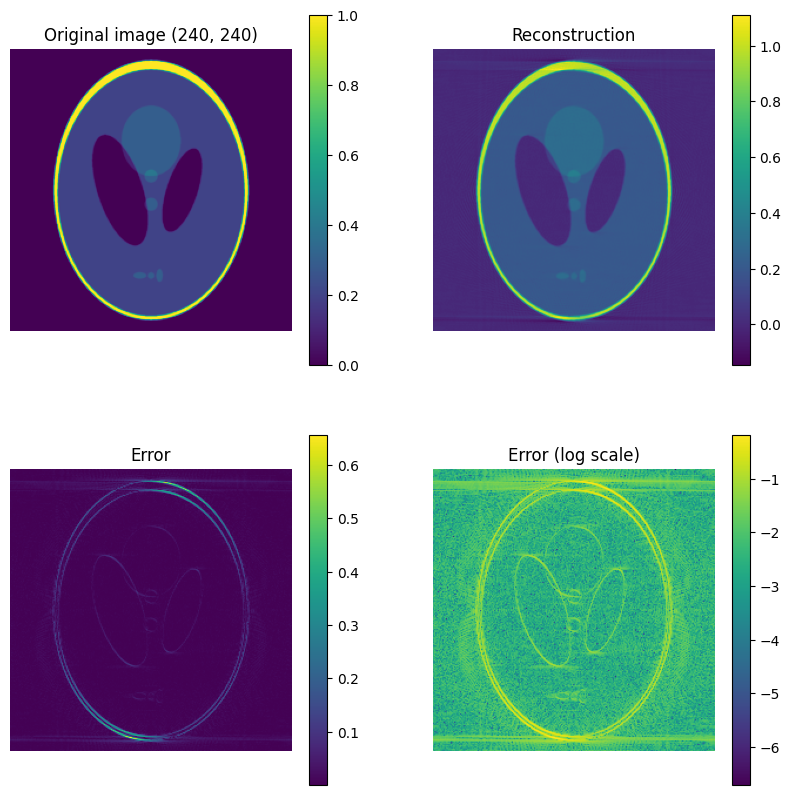

In [11]:
sol = sol_direct.real

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

a = axes[0, 0].imshow(phantom)
plt.colorbar(a, ax=axes[0, 0])
axes[0, 0].set_title(f"Original image {phantom.shape}")

a = axes[0, 1].imshow(sol)
plt.colorbar(a, ax=axes[0, 1])
axes[0, 1].set_title(f"Reconstruction")

a = axes[1, 0].imshow(np.abs(sol - phantom))
plt.colorbar(a, ax=axes[1, 0])
axes[1, 0].set_title("Error")

a = axes[1, 1].imshow(np.log10(np.abs(sol - phantom)))
plt.colorbar(a, ax=axes[1, 1])
axes[1, 1].set_title("Error (log scale)")

[ax.set_axis_off() for ax in axes.ravel()]

# Try bigger image

In [39]:
def create_shepp_logan_2(n):
    x, y = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    xx, yy = np.meshgrid(x, y)
    res = np.zeros_like(xx)

    A_list = [1, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        rot_x = xx * np.cos(phi) + yy * np.sin(phi)
        rot_y = - np.sin(phi) * xx + yy * np.cos(phi)
        mask = (rot_x - x0)**2 / a**2 + (rot_y - y0)**2 / b**2 <= 1
        res[mask] += A

    return res[::-1]

In [47]:
n = 500
im = create_shepp_logan_2(500)

In [48]:
m = 2 * n + 1

theta = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n) # with n projections this time

proj = Projection(im.shape, angles=theta)
sinogram = proj.projection(im)

In [49]:
precomputations = precompute_all(n)

In [54]:
sol = fast_reconstruction(sinogram, precomputations, angles=theta, tol=None)

[None, None, None, None]

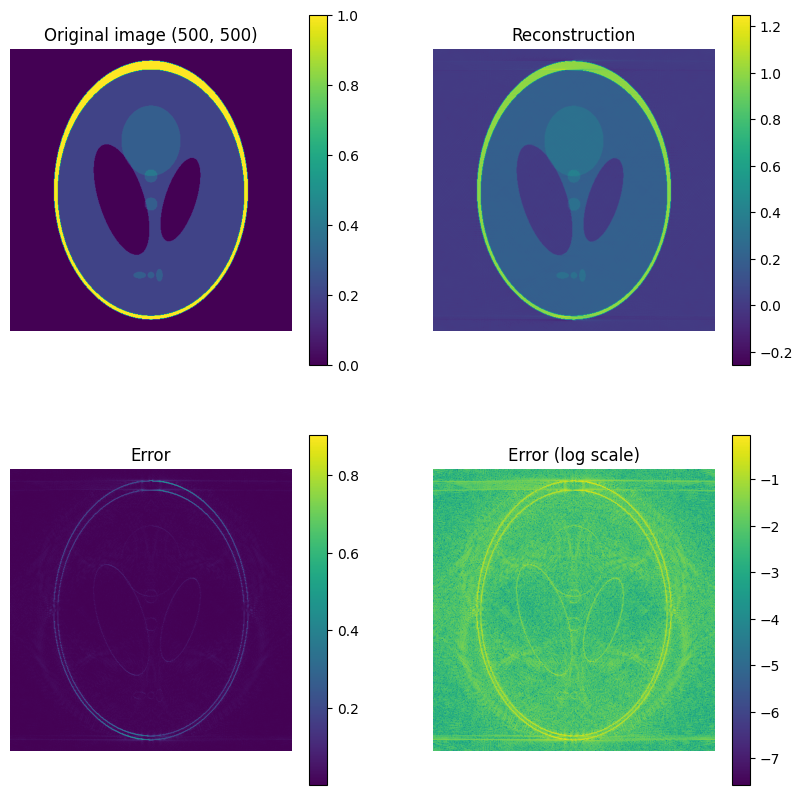

In [55]:
sol = sol.real

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

a = axes[0, 0].imshow(im)
plt.colorbar(a, ax=axes[0, 0])
axes[0, 0].set_title(f"Original image {im.shape}")

a = axes[0, 1].imshow(sol)
plt.colorbar(a, ax=axes[0, 1])
axes[0, 1].set_title(f"Reconstruction")

a = axes[1, 0].imshow(np.abs(sol - im))
plt.colorbar(a, ax=axes[1, 0])
axes[1, 0].set_title("Error")

a = axes[1, 1].imshow(np.log10(np.abs(sol - im)))
plt.colorbar(a, ax=axes[1, 1])
axes[1, 1].set_title("Error (log scale)")

[ax.set_axis_off() for ax in axes.ravel()]

# Step by step to see how long each step is

In [18]:
n = 500
im = create_shepp_logan_2(500)
m = 2 * n + 1
theta = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n) # with n projections this time
proj = Projection(im.shape, angles=theta)
sinogram = proj.projection(im)
pad_sino = pad(sinogram, (n, m))
fft_sinogram = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pad_sino, axes=-1)), axes=-1)

In [19]:
p = np.arange(-n, n + 1)
x_polar = p[None, :] * np.cos(np.pi / 2 + theta)[:, None]
y_polar = p[None, :] * np.sin(np.pi / 2 + theta)[:, None]    

In [20]:
hori_ppfft, vert_ppfft = direct_2d_interp(fft_sinogram, x_polar, y_polar, n)

In [21]:
precomputations = precompute_all(n)

In [22]:
sol_direct = fast_direct_inversion(hori_ppfft, vert_ppfft, precomputations)

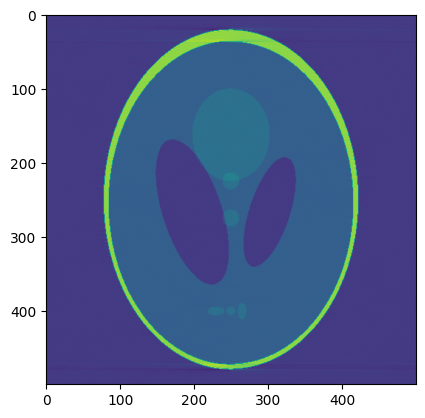

In [23]:
plt.imshow(sol_direct.real)

# Try with the 1D interpolations

In [24]:
from ppfft.reconstruction.polar_to_pp import new_polar_to_pseudopolar

In [25]:
n = 2000
im = create_shepp_logan_2(n)
m = 2 * n + 1
theta = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n) # with n projections this time
proj = Projection(im.shape, angles=theta)
sinogram = proj.projection(im)
pad_sino = pad(sinogram, (n, m))
fft_sinogram = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(pad_sino, axes=-1)), axes=-1)

In [26]:
precomputations = precompute_all(n)

In [27]:
hori_ppfft, vert_ppfft = new_polar_to_pseudopolar(fft_sinogram.T)

In [28]:
sol_1d = fast_direct_inversion(hori_ppfft, vert_ppfft, precomputations)

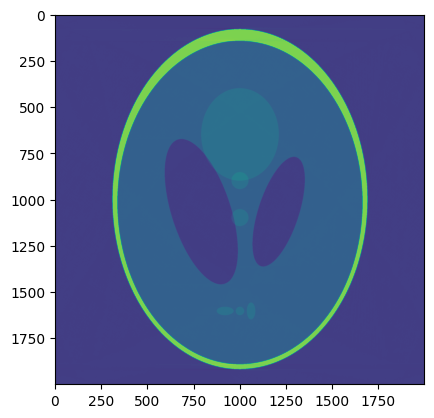

In [29]:
plt.imshow(sol_1d.real)

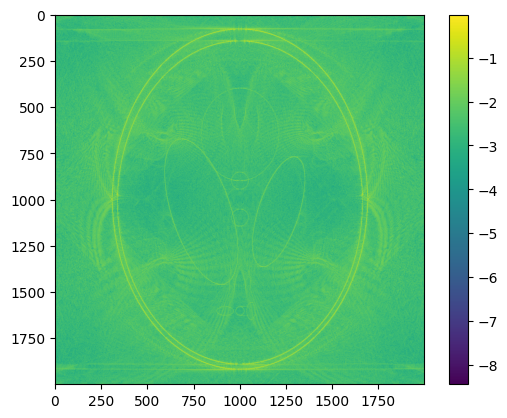

In [30]:
plt.imshow(np.log10(np.abs(sol_1d.real - im)))
plt.colorbar()